This problem set is provided to help you get used to PyTorch.

Only fill parts marked with "`Your code here`" comments, don't erase or change the rest.

<font color="red">**You are NOT ALLOWED to:**</font>
* use NumPy or any other tensor library except PyTorch;
* emulate PyTorch tensors (i.e. large arrays of numbers) with lists or tuples;
* emulate any tensor functionality with other libraries/loops/indexing if it's directly native to PyTorch. Example:

```python
x = torch.rand(1_000_000)

# Wrong: slow and unreadable
for idx in range(x.numel()):
    x[idx] = math.sqrt(x[idx])

# Correct
x.sqrt_()
```

# Homework 2, *part 1*
### (40 points total)

**In this part only**, you are <font color="red">**NOT ALLOWED**</font> to use any PyTorch submodules, including
* `torch.nn`,
* `torch.nn.functional` (in general, try to always avoid using it),
* `torch.optim`,
* `torch.utils.data`.

Instead, use only PyTorch core functions, such as `torch.avg_pool1d(x)` or `torch.no_grad()`. Where possible, use special operators syntax (e.g. `x @ y`, `x += 17`, `x[None]`) or tensor methods (e.g. `x.to(y)`, `x.prelu()`, `x.copy_(y)`).

**You are required** to format your notebook cells so that `Run All` command on a fresh notebook
* displays all the required plots in tasks 1 and 2;
* within 15 seconds, **reliably** trains your model in task 3 to the desired accuracy and reports the accuracy reached.

In [6]:
import numpy as np               # results verification during grading
import math                      # Pi

import matplotlib.pyplot as plt  # 2D plot in task 1
%matplotlib inline

import torch
assert torch.__version__ >= '1.3.0'

In [7]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/Deep Learning 2020 -- Home Assignment 2")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.insert(0, str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

In [8]:
# Import the custom libraries
from animation import Animation    # animations in task 2
from notmnist import load_notmnist # dataset for task 3

While learning PyTorch, you will have lots of questions, e.g.

* how to choose between `.sqrt()` and `.sqrt_()`,
* when to use `.view()` and how is it different from `.reshape()`,
* which `dtype` to use etc.

To find the answers, you are expected to study [documentation](https://pytorch.org/docs/stable/index.html) and google a lot.

If this is your first PyTorch experience, you may want to [start here](https://pytorch.org/tutorials/).

Quick documentation on functions and modules is available with `?` and `help()`, like so:

In [9]:
help(torch.sqrt)

Help on built-in function sqrt:

sqrt(...)
    sqrt(input, out=None) -> Tensor
    
    Returns a new tensor with the square-root of the elements of :attr:`input`.
    
    .. math::
        \text{out}_{i} = \sqrt{\text{input}_{i}}
    
    Args:
        input (Tensor): the input tensor.
        out (Tensor, optional): the output tensor.
    
    Example::
    
        >>> a = torch.randn(4)
        >>> a
        tensor([-2.0755,  1.0226,  0.0831,  0.4806])
        >>> torch.sqrt(a)
        tensor([    nan,  1.0112,  0.2883,  0.6933])



In [10]:
# to close the Jupyter help bar, press `Esc` or `q`
?torch.cat

## Task 1 (3 points)

**Use 64-bit floating point tensors for this task**.

$\rho(\theta)$ is defined in polar coordinate system:

$$\rho(\theta) = (1 + 0.9 \cdot \cos{8\theta} ) \cdot (1 + 0.1 \cdot \cos{24\theta}) \cdot (0.9 + 0.05 \cdot \cos {200\theta}) \cdot (1 + \sin{\theta})$$

1. Create a regular grid of 1000 values of $\theta$ between $-\pi$ and $\pi$.
2. Compute $\rho(\theta)$ at these points.
3. Convert the result into Cartesian coordinates ([see here how](http://www.mathsisfun.com/polar-cartesian-coordinates.html)).

In [11]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [12]:
theta = torch.linspace( - torch.acos(torch.zeros(1)).item() * 2, torch.acos(torch.zeros(1)).item() * 2, steps = 1000)
assert theta.shape == (1000,)

rho = (1 + 0.9 * torch.cos(8 * theta)) * (1 + 0.1 * torch.cos(24 * theta)) * (0.9 + 0.05 * torch.cos(200 * theta)) * (1 + torch.sin(theta))
assert torch.is_same_size(rho, theta)

x = torch.mul(rho, torch.cos(theta))
y = rho * torch.sin(theta)

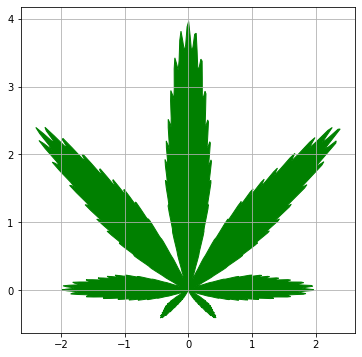

In [13]:
# Run this cell and make sure the plot is correct
plt.figure(figsize=(6,6))
plt.fill(x, y, color='green')
plt.grid()

In [14]:
assert \
    np.allclose(x.sum(), -1.9854999999997989, atol=1e-4) and \
    np.allclose(y.mean(), 0.44955, atol=1e-4), \
    "Task 1: you've made an error somewhere"
print("Task 1: well done!")

Task 1: well done!


## Task 2 (7 points)

We will implement [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway's_Game_of_Life) in PyTorch.

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)

In case you skipped the above hyperlink, here are the rules:
* You have a 2D grid of cells, where each cell is "alive" or "dead" (has a value of `1` or `0` respectively).
* At each step in time, the so-called "generation update" happens:
  * any alive cell that has 2 or 3 neighbors survives, otherwise (0, 1 or 4+ neighbors) it dies;
  * any cell with exactly 3 neighbors becomes alive if it was dead.

You are given a reference numpy implementation of the generation update. Your task is to convert it to PyTorch. Try to avoid datatype conversions.

In [15]:
from scipy.signal import correlate2d as conv2d

def game_of_life_update_numpy(alive_map):
    """
    Game of Life update function.
    
    alive_map:
        `numpy.ndarray`, ndim == 2, dtype == `np.int64`
        The game map containing 0s (dead) an 1s (alive).
    """
    # Count neighbours with convolution
    conv_kernel = np.array([[1,1,1],
                            [1,0,1],
                            [1,1,1]], dtype=np.int64)
    
    num_alive_neighbors = conv2d(alive_map, conv_kernel, mode='same')
    # Apply game rules
    born = np.logical_and(num_alive_neighbors == 3, alive_map == 0)
    survived = np.logical_and(np.isin(num_alive_neighbors, [2,3]), alive_map == 1)
    np.copyto(alive_map, np.logical_or(born, survived))

In [16]:
def game_of_life_update_torch(alive_map):
    """
    PyTorch version of `game_of_life_update_numpy`.
    
    alive_map:
        `torch.tensor`, ndim == 2, dtype == `torch.int64`
        The game map containing 0s (dead) an 1s (alive).
    """
    # Count neighbours with convolution
    conv_kernel = torch.FloatTensor([[1,1,1],
                                [1,0,1],
                                [1,1,1]])
    
    conv = torch.nn.Conv2d(in_channels = 1, out_channels = 1,
                                      kernel_size = conv_kernel.size(),padding = 1, padding_mode='zeros')
    conv.weight[0] = conv_kernel
    conv.bias[0] = 0
    num_alive_neighbors = conv(alive_map_torch[None,None,:,:].type(torch.float32))

    # Apply game rules
    born = torch.where(((num_alive_neighbors == 3) & (alive_map == 0)), 
                       torch.ones_like(alive_map), torch.zeros_like(alive_map))
    survived = torch.where(((num_alive_neighbors == 3) & (alive_map == 1) | (num_alive_neighbors == 2) & (alive_map == 1)), 
                        torch.ones_like(alive_map), torch.zeros_like(alive_map))
    
    alive_map.data = torch.max(born[0,0],survived[0,0])
    alive_map.type(torch.float32)

In [17]:
for _ in range(10):
    # Generate a random initial map
    alive_map_numpy = np.random.choice([0, 1], p=(0.5, 0.5), size=(100, 100))
    alive_map_torch = torch.from_numpy(alive_map_numpy).clone()

    game_of_life_update_numpy(alive_map_numpy)
    game_of_life_update_torch(alive_map_torch)
    # Results must be identical\
    assert np.allclose(alive_map_torch.numpy(), alive_map_numpy), \
        "Your PyTorch implementation doesn't match numpy_update."

print("Task 2: well done!")

Task 2: well done!


In [18]:
animation = Animation(monochrome=True)

# Initialize game field
np.random.seed(666)
alive_map = np.random.choice([0, 1], size=(100, 100))
alive_map = torch.from_numpy(alive_map)

for _ in range(101):
    animation.add_image((alive_map * 255).byte().numpy()[:, :, None])
    game_of_life_update_torch(alive_map)
animation.display()

In [15]:
animation = Animation(monochrome=True)

# A fun setup for your amusement
alive_map = np.arange(100) % 2 + np.zeros((100, 100), dtype=np.int64)
alive_map[48:52, 50] = 1

alive_map = torch.from_numpy(alive_map)

for _ in range(150):
    animation.add_image((alive_map * 255).byte().numpy()[:, :, None])
    game_of_life_update_torch(alive_map)

animation.display()

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE)

## Task 3 (30 points)

You have to solve yet another character recognition problem: *notMNIST* dataset of 10 letters and ~14 000 train samples.

For this, we ask you to build a multilayer perceptron (*i.e. a neural network of linear layers*) from scratch using **low-level** PyTorch interface.

Requirements:
1. at least 82% validation accuracy,
2. at least 2 linear layers,
3. no convolutions,
3. use [softmax followed by categorical cross-entropy](https://gombru.github.io/2018/05/23/cross_entropy_loss/).

Tips:

* Don't use the structures from homework 1 (`Sequential`, `.forward()` etc.). I suggest that your `NeuralNet.predict()` consists of 5-7 lines.
* Pick random batches (either shuffle data before each epoch or sample each batch randomly).
* Do not initialize weights with zeros ([learn why](https://stats.stackexchange.com/questions/27112/danger-of-setting-all-initial-weights-to-zero-in-backpropagation)). Gaussian noise with small variance will do.
* 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve.
* To improve accuracy, consider changing layers' sizes, nonlinearities, optimization methods, weights initialization.
* Don't use GPU yet.

Happy googling!

In [19]:
letters = 'ABCDEFGHIJ'
X_train, y_train, X_val, y_val = map(torch.tensor, load_notmnist(letters=letters))
X_train.squeeze_()
X_val.squeeze_();

Parsing... (it's OK if <10 images are broken)
Found broken image: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png
Found broken image: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png


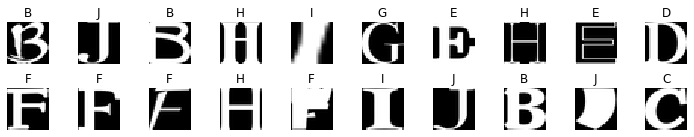

In [20]:
fig, axarr = plt.subplots(2, 10, figsize=(10, 2))

for idx, ax in enumerate(axarr.ravel()):
    ax.imshow(X_train[idx], cmap='gray')
    ax.axis('off')
    ax.set_title(letters[y_train[idx]])

fig.tight_layout()

In [21]:
X_train = X_train.view(X_train.size(0), -1)
X_val = X_val.view(X_val.size(0), -1)

#y_train = torch.eye(10)[y_train]
#y_val = torch.eye(10)[y_val]

In [22]:
np.random.seed(666)
torch.manual_seed(666);

The cell below has an example layout for encapsulating your neural network. Feel free to modify the interface if you need to (add arguments, add return values, add methods etc.). For example, you may want to add a method `do_gradient_step()` that executes one optimization algorithm (SGD / Adadelta / Adam / ...) step.

In [26]:
class NeuralNet:
    def __init__(self, n_in, n_out1, n_out2):
        # Your code here
        self.W1 = (1e-3*torch.rand(size = [n_out1, n_in])).requires_grad_(True)
        self.b1 = (1e-3*torch.rand(size = [1, n_out1])).requires_grad_(True)

        self.W2 = (1e-3*torch.rand(size = [n_out2, n_out1])).requires_grad_(True)
        self.b2 = (1e-3*torch.rand(size = [1, n_out2])).requires_grad_(True)


    def predict(self, images):
        """
        images:
            `torch.tensor`, shape == `batch_size x height x width`, dtype == `torch.float32`
            A minibatch of images -- the input to the neural net.
        
        return:
        prediction:
            `torch.tensor`, shape == `batch_size x 10`, dtype == `torch.float32`
            The probabilities of each input image to belong to each of the dataset classes.
            Namely, `output[i, j]` is the probability of `i`-th
            minibatch sample to belong to `j`-th class.
        """
        # Your code here
  
        res1 = torch.matmul(images, torch.transpose(self.W1, 0, 1)) + self.b1
        res1_relu = torch.max(res1, torch.zeros_like(res1))
        res2 = torch.matmul(res1_relu, torch.transpose(self.W2, 0, 1)) + self.b2
        res2_soft= res2.softmax(dim = 1)
        return res2_soft 

    # Your code here
    def zeroGradParameters(self):
        self.W1.grad = torch.zeros_like(self.W1)
        self.W2.grad = torch.zeros_like(self.W2)
        self.b1.grad = torch.zeros_like(self.b1)
        self.b2.grad = torch.zeros_like(self.b2)

    def do_gradient_step(self, lr):
        
        self.W1.data = self.W1.data - lr * self.W1.grad
        self.W2.data = self.W2.data - lr * self.W2.grad
        self.b1.data = self.b1.data - lr * self.b1.grad
        self.b2.data = self.b2.data - lr * self.b2.grad

    def loss(self, images, labels):
        predictions = self.predict(images)
        predictions_stable = torch.clamp(predictions, min = 1e-11, max = 1 - 1e-11)
        loss = - torch.sum(torch.log(predictions_stable[torch.arange(len(labels)),labels])) 
        loss.data = loss.data / len(labels)
        return loss

In [27]:
# batch generator from HW1
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start ofFa epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]

In [28]:
def accuracy(model, images, labels):
    """
    model:
        `NeuralNet`
    images:
        `torch.tensor`, shape == `N x height x width`, dtype == `torch.float32`
    labels:
        `torch.tensor`, shape == `N`, dtype == `torch.int64`
        Class indices for each sample in `images`.
    
    return:
    value:
        `float`
        The fraction of samples from `images` correctly classified by `model`.
        `0 <= value <= 1`. 
    """
    # Your code here
    y_pred = model.predict(images.reshape([len(images), 784]))
    y_pred_argmax = torch.argmax(y_pred, dim = 1)
    correct = torch.sum(torch.eq(y_pred_argmax, labels))
    fraction = torch.div(correct, torch.tensor(labels.size(), dtype = torch.float))
    return fraction.data.tolist()[0]

In [29]:
from tqdm import tqdm

In [34]:
model = NeuralNet(n_in = 784, n_out1 = 50, n_out2 = 10)
lr = 1e-3
n_epoch = 20
batch_size = 250

In [35]:
for i in tqdm(range(n_epoch)):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        predictions = model.predict(x_batch)
        model.zeroGradParameters()
        loss = model.loss(x_batch, y_batch)
        loss.backward()
        model.do_gradient_step(lr)
        y_batch.size()

100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


In [36]:
train_accuracy = accuracy(model, X_train, y_train) * 100
val_accuracy = accuracy(model, X_val, y_val) * 100
print("Training accuracy: %.2f, validation accuracy: %.2f" % (train_accuracy, val_accuracy))

assert val_accuracy >= 82.0, "You have to do better"
print("Task 3: well done!")

Training accuracy: 96.83, validation accuracy: 90.15
Task 3: well done!
